In [ ]:
# Install the ml4floods package

!pip install ml4floods

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 54.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl 

In [ ]:
import os
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
from ml4floods.models.config_setup import get_default_config
from ml4floods.models.model_setup import get_model
from ml4floods.models.model_setup import get_model_inference_function
from ml4floods.models.model_setup import get_channel_configuration_bands
from ml4floods.visualization import plot_utils
from ml4floods.data.worldfloods import dataset
import torch
import matplotlib.pyplot as plt
from ml4floods.models import postprocess
from ml4floods.visualization import plot_utils
import geopandas as gpd
import numpy as np

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    assert os.path.exists('/content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder/worldfloods_v1_0_sample'), "Add a shortcut to the publice Google Drive folder: https://drive.google.com/drive/u/0/folders/1dqFYWetX614r49kuVE3CbZwVO6qHvRVH"
    google_colab = True
    path_to_dataset_folder = '/content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder/worldfloods_v1_0_sample'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    experiment_name = "WFV1_unet"
    folder_name_model_weights = os.path.join(path_to_dataset_folder, 'checkpoints', experiment_name)
except ImportError as e:
    print(e)
    print("Setting google colab to false, it will need to install the gdown package!")
    google_colab = False

Mounted at /content/drive


### Step 0b: Download the data with the gdown package

In [ ]:
# Download pre-trained model from Google Drive folder
if not google_colab:
    experiment_name = "WFV1_unet"
    # Download val folder
    path_to_dataset_folder = '.'
    dataset_folder = os.path.join(path_to_dataset_folder, "worldfloods_v1_0_sample")
    val_folder = os.path.join(dataset_folder, "val")

    folder_name_model_weights = os.path.join(path_to_dataset_folder,"checkpoints",experiment_name)

    if not os.path.exists(folder_name_model_weights):
        import gdown
        gdown.download_folder(id="1Oup-qVD1U-re3lIQkw7TOKJsdu90blsk", quiet=False, use_cookies=False,
                              output=folder_name_model_weights)

    if not os.path.exists(val_folder):
        import gdown
        os.makedirs(val_folder, exist_ok=True)
        # https://drive.google.com/drive/folders/1ogcNupGr0q6nLwS7BBQQ8PzILyONah12?usp=sharing
        gdown.download_folder(id="1ogcNupGr0q6nLwS7BBQQ8PzILyONah12", quiet=False, use_cookies=False,
                              output=val_folder)

In [ ]:
folder_name_model_weights

'/content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder/worldfloods_v1_0_sample/checkpoints/WFV1_unet'

## Step 1: Get config

In [ ]:


config_fp = os.path.join(folder_name_model_weights, "config.json")

config = get_default_config(config_fp)

# The max_tile_size param controls the max size of patches that are fed to the NN. If you're in a memory contrained environment set this value to 128
config["model_params"]["max_tile_size"] = 128

## Step 2: Load pre-trained model

In [ ]:
config.model_params['model_folder']

'gs://ml4cc_data_lake/0_DEV/2_Mart/2_MLModelMart'

In [ ]:


model_path = "/content/worldfloods_v1_0_sample/checkpoints/WFV1_unet/model.pt"

model_folder = os.path.dirname(folder_name_model_weights)
if model_folder == "":
    model_folder = "."

config["model_params"]['model_folder'] = model_folder
config["model_params"]['test'] = True
model = get_model(config.model_params, experiment_name)

model.eval()
model.to("cuda") # comment this line if your machine does not have GPU

Loaded model weights: /content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder/worldfloods_v1_0_sample/checkpoints/WFV1_unet/model.pt


WorldFloodsModel(
  (network): UNet(
    (dconv_down1): Sequential(
      (0): Conv2d(13, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (dconv_down4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

In [ ]:


inference_function = get_model_inference_function(model, config,apply_normalization=True)

Getting model inference function


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Step 3: Run Inference

In the next cell we load a GeoTIFF Sentinel-2 from the *WorldFloods* `val` dataset and we run the segmentation model on it. Afterwards we load the ground truth and the JRC permanent water layer GeoTIFF and plot it for comparison purposes.

In [ ]:
!ls '/content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder/worldfloods_v1_0_sample/val/S2'

EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif
EMSR279_05ZARAGOZA_DEL_MONIT02_v1_observed_event_a.tif
EMSR280_03FALUN_DEL_MONIT06_v2_observed_event_a.tif
EMSR287_05MAGWITZ_DEL_v1_observed_event_a.tif
RS2_20161008_Water_Extent_Corail_Pestel.tif
ST1_20161014_WaterExtent_BinhDinh_Lake.tif


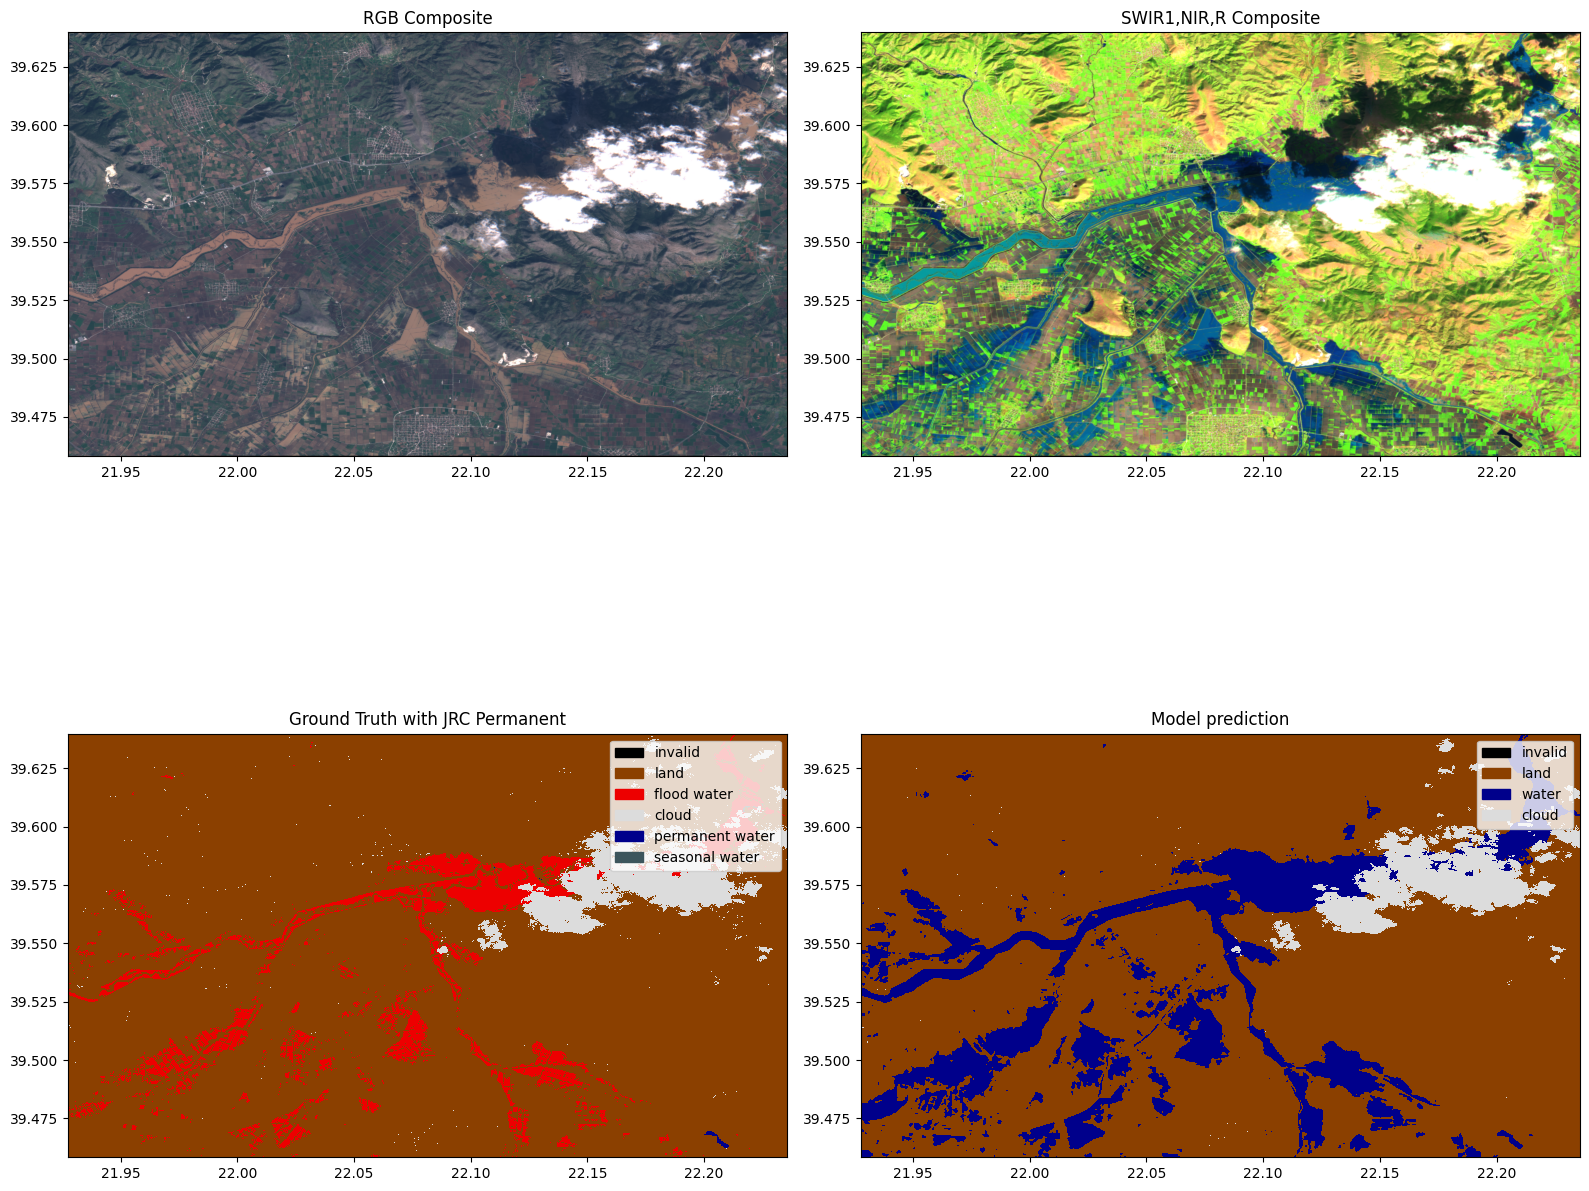

In [ ]:


channel_configuration = config.model_params.hyperparameters.channel_configuration

dataset_folder = '/content/drive/MyDrive/Public WorldFloods Dataset/Untitled Folder/worldfloods_v1_0_sample'
# dataset_folder = gs://ml4cc_data_lake/2_PROD/2_Mart/worldfloods_v1_0/
event_id = "EMSR271_02FARKADONA_DEL_v1_observed_event_a.tif"
tiff_s2 = os.path.join(dataset_folder, "val", "S2", event_id)
tiff_gt = os.path.join(dataset_folder, "val", "gt", event_id)
tiff_permanentwaterjrc = os.path.join(dataset_folder, "val", "PERMANENTWATERJRC", event_id)
window = None
channels = get_channel_configuration_bands(channel_configuration)

# Read inputs
torch_inputs, transform = dataset.load_input(tiff_s2, window=window, channels=channels)

# Make predictions
outputs = inference_function(torch_inputs.unsqueeze(0))[0] # (num_classes, h, w)
prediction = torch.argmax(outputs, dim=0).long() # (h, w)

# Mask invalid pixels
mask_invalid = torch.all(torch_inputs == 0, dim=0)
prediction+=1
prediction[mask_invalid] = 0

# Load GT and permanent water for plotting
torch_targets, _ = dataset.load_input(tiff_gt, window=window, channels=[0])
torch_permanent_water, _ = dataset.load_input(tiff_permanentwaterjrc, window=window, channels=[0])


# Plot
fig, axs = plt.subplots(2,2, figsize=(16,16))
plot_utils.plot_rgb_image(torch_inputs, transform=transform, ax=axs[0,0])
axs[0,0].set_title("RGB Composite")
plot_utils.plot_swirnirred_image(torch_inputs, transform=transform, ax=axs[0,1])
axs[0,1].set_title("SWIR1,NIR,R Composite")
plot_utils.plot_gt_v1_with_permanent(torch_targets, torch_permanent_water, window=window, transform=transform, ax=axs[1,0])
axs[1,0].set_title("Ground Truth with JRC Permanent")
plot_utils.plot_gt_v1(prediction.unsqueeze(0),transform=transform, ax=axs[1,1])
axs[1,1].set_title("Model prediction")
plt.tight_layout()


## 4: Vectorise the water masks and plot them



<Axes: >

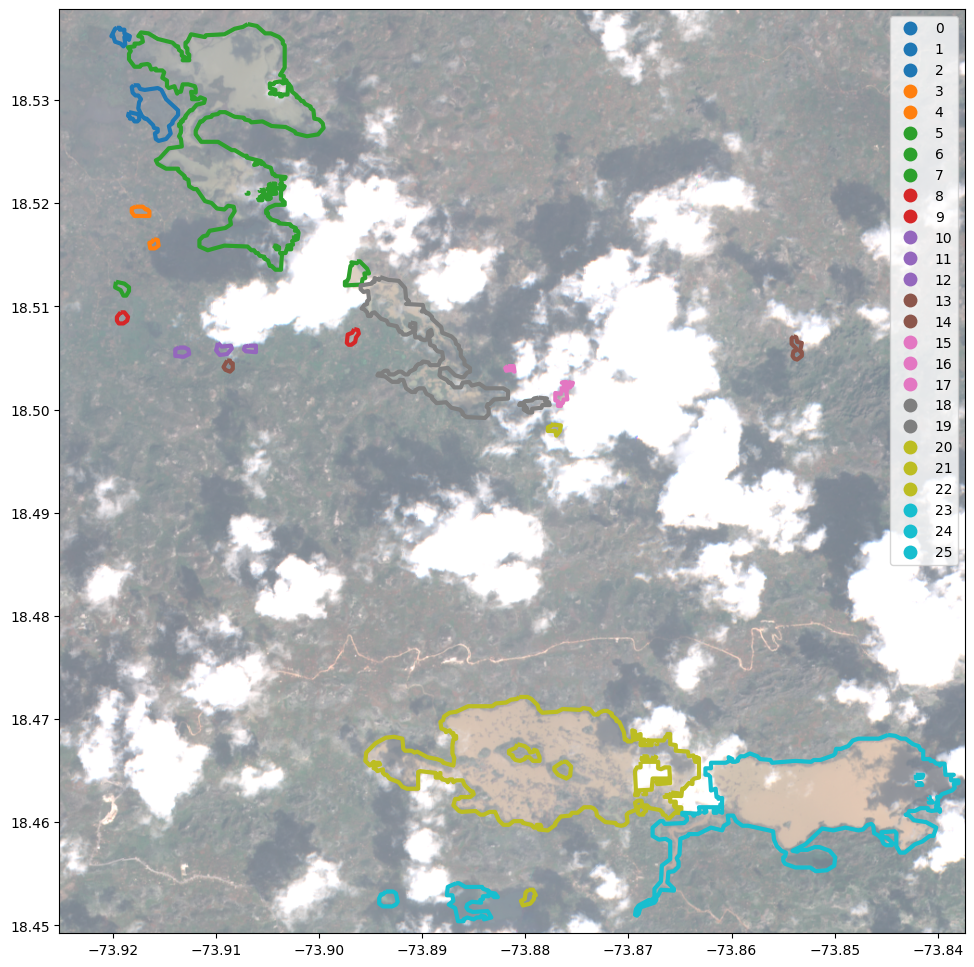

In [ ]:
prob_water_mask = outputs[1].cpu().numpy()
binary_water_mask = prob_water_mask>.5

geoms_polygons = postprocess.get_water_polygons(binary_water_mask, transform=transform)

data_out = gpd.GeoDataFrame({"geometry": geoms_polygons, "id": np.arange(len(geoms_polygons))})
fig, ax = plt.subplots(1,1, figsize=(12, 12))
data_out.plot("id",legend=True,categorical=True,ax=ax,facecolor="None",edgecolor=None,linewidth=3)
plot_utils.plot_rgb_image(torch_inputs, transform=transform, ax=ax, alpha=.6,
                             channel_configuration=channel_configuration)